<a href="https://colab.research.google.com/github/hwon-n/cp2/blob/hyewon/CP2_KoSpacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 띄어쓰기 검사 모델 구현하기

## 필요한 패키지 다운로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [3]:
pip install pytorch-lightning

     |████████████████████████████████| 527 kB 4.0 MB/s 
     |████████████████████████████████| 134 kB 71.1 MB/s 
     |████████████████████████████████| 952 kB 68.2 MB/s 
     |████████████████████████████████| 829 kB 60.7 MB/s 
     |████████████████████████████████| 596 kB 56.9 MB/s 
     |████████████████████████████████| 397 kB 68.7 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
     |████████████████████████████████| 94 kB 4.7 MB/s 
     |████████████████████████████████| 144 kB 74.2 MB/s 
     |████████████████████████████████| 271 kB 74.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=fde832a8a4c277c49ce562d46d1e586b82fe6ba0490d94e228bee4e4fe9d66e5
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

In [4]:
pip install omegaconf

     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 112 kB 8.8 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=11a05a8519907df45d0ac098d5cf75b09e3be1d93dfd9f01a53f56a497a80d82
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime


In [5]:
pip install seqeval

     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=8690376233279042c1fcf708b386801d8721949477df757a2d7c6d65470e45ed
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [6]:
pip install torch

In [7]:
pip install tokenizers

     |████████████████████████████████| 6.5 MB 4.4 MB/s 


In [8]:
pip install transformers

     |████████████████████████████████| 3.8 MB 4.4 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 57.7 MB/s 


## 데이터 불러오기

In [28]:
import os

root = '/content/drive/MyDrive/news_class9x1400/'
categories = os.listdir(root)

dataset = []

for cat in categories:
  files = os.listdir(root + cat)
  for i, f in enumerate(files):
    fname = root + cat + '/' + f
    file = open(fname, 'r', encoding='utf-8')
    strings = file.read()
    dataset.append([strings])
    file.close()

print(len(dataset))

12600


## 데이터 전처리

In [31]:
table = str.maketrans({
    '\'': '',
    '\"': '',
    '★': '',
    '▲': '',
    '┌': '',
    '├': '',
    '│': '',
    '└': '',
    '→': ''

})
test = '"안녕"하세★요? 좋은 아▲침입┌니├다. 오│늘도 힘내└세요→!'
test = test.translate(table)

test

'안녕하세요? 좋은 아침입니다. 오늘도 힘내세요!'

In [32]:
process_dataset = []

for sentences in dataset:
  sentences = sentences[0]
  sentences = sentences.translate(table)
  sentences = sentences.split("\n")
  process_dataset.extend(sentences)


len(process_dataset)

511586

In [33]:
process_dataset = process_dataset[:80000]

In [34]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(process_dataset, test_size = 0.2, random_state  = 42)
train, val = train_test_split(train, test_size = 0.2, random_state = 42)

print(len(train), len(val), len(test))

51200 12800 16000


In [35]:
def save_datafile(file_name, dataset):
  with open(
      os.path.join(root, file_name), mode = 'w', encoding='utf-8'
  ) as f:
    for data in dataset:
      f.write(data)

save_datafile('train.txt', train)
save_datafile('val.txt', val)
save_datafile('test.txt', test)

print('train, val, test dataset 저장 완료!')

train, val, test dataset 저장 완료!


In [36]:
train[1123]

'전주에만 있는 음식? 우선 전주한정식과 비빔밥을 추천해주었다.'

In [37]:
val[3452]

'멀티 매스 미디어의 역할이든 개인 미디어의 역할이든 소셜미디어가 기존 언론매체의 역할을 대신하는 대안언론으로서 자리를 굳히고 있다는 사실만은 분명해 보인다.'

In [38]:
test[999]

'그녀의 작품은 화려하지 않다.'

## 띄어쓰기를 위한 클래스

In [9]:
from typing import List

def load_slot_labels() -> List[str]:
    """tag label 종류 리턴"""
    return ["UNK", "PAD", "O", "B", "I", "E", "S"]

In [10]:
from typing import Callable, List, Tuple
from torch.utils.data import Dataset

class CorpusDataset(Dataset):
    def __init__(self, data_path: str, transform: Callable[[List, List], Tuple]):
        self.sentences = []
        self.transform = transform
        self.slot_labels = load_slot_labels()

        self._load_data(data_path)

    def _load_data(self, data_path: str):
        """data를 file에서 불러온다.
        Args:
            data_path: file 경로
        """
        with open(data_path, mode="r", encoding="utf-8") as f:
            lines = f.readlines()
            self.sentences = [line.split() for line in lines]

    def _get_tags(self, sentence: List[str]) -> List[str]:
        """문장에 대해 띄어쓰기 tagging을 한다.
        character 단위로 분리하여 BIES tagging을 한다.
        Args:
            sentence: 문장
        Retrns:
            문장의 각 토큰에 대해 tagging한 결과 리턴
            ["B", "I", "E"]
        """

        all_tags = []
        for word in sentence:
            if len(word) == 1:
                all_tags.append("S")
            elif len(word) > 1:
                for i, c in enumerate(word):
                    if i == 0:
                        all_tags.append("B")
                    elif i == len(word) - 1:
                        all_tags.append("E")
                    else:
                        all_tags.append("I")
        return all_tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = "".join(self.sentences[idx])
        tags = self._get_tags(self.sentences[idx])
        tags = [self.slot_labels.index(t) for t in tags]

        (
            input_ids,
            slot_labels,
            attention_mask,
            token_type_ids,
        ) = self.transform(sentence, tags)

        return input_ids, slot_labels, attention_mask, token_type_ids

### Tokenization_kobert


In [11]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBERT model """


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [12]:
import torch

class Preprocessor:
    def __init__(self, max_len: int):
        self.tokenizer = KoBertTokenizer.from_pretrained("monologg/kobert")
        self.max_len = max_len
        self.pad_token_id = 0

    def get_input_features(
        self, sentence: List[str], tags: List[str]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """문장과 띄어쓰기 tagging에 대해 feature로 변환한다.
        Args:
            sentence: 문장
            tags: 띄어쓰기 tagging
        Returns:
            feature를 리턴한다.
            input_ids, attention_mask, token_type_ids, slot_labels
        """

        input_tokens = []
        slot_labels = []

        for word, tag in zip(sentence, tags):
            tokens = self.tokenizer.tokenize(word)

            if len(tokens) == 0:
                tokens = self.tokenizer.unk_token

            input_tokens.extend(tokens)

            for i, _ in enumerate(tokens):
                if i == 0:
                    slot_labels.extend([tag])
                else:
                    slot_labels.extend([self.pad_token_id])

        # 2. max_len보다 길이가 길면 뒤에 자르기
        if len(input_tokens) > self.max_len - 2:
            input_tokens = input_tokens[: self.max_len - 2]
            slot_labels = slot_labels[: self.max_len - 2]

        # cls, sep 추가
        input_tokens = (
            [self.tokenizer.cls_token] + input_tokens + [self.tokenizer.sep_token]
        )
        slot_labels = [self.pad_token_id] + slot_labels + [self.pad_token_id]

        # token을 id로 변환
        input_ids = self.tokenizer.convert_tokens_to_ids(input_tokens)

        attention_mask = [1] * len(input_ids)
        token_type_ids = [0] * len(input_ids)

        # padding
        pad_len = self.max_len - len(input_tokens)
        input_ids = input_ids + ([self.tokenizer.pad_token_id] * pad_len)
        slot_labels = slot_labels + ([self.pad_token_id] * pad_len)
        attention_mask = attention_mask + ([0] * pad_len)
        token_type_ids = token_type_ids + ([0] * pad_len)

        input_ids = torch.tensor(input_ids, dtype=torch.long)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)
        slot_labels = torch.tensor(slot_labels, dtype=torch.long)

        return input_ids, attention_mask, token_type_ids, slot_labels

## 모델 생성

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import BertConfig, BertModel, AdamW
from torch.utils.data import DataLoader
from seqeval.metrics import f1_score


class SpacingBertModel(pl.LightningModule):
    def __init__(
        self,
        config,
        ner_train_dataloader: DataLoader,
        ner_val_dataloader: DataLoader,
        ner_test_dataloader: DataLoader,
    ):
        super().__init__()
        self.config = config
        self.ner_train_dataloader = ner_train_dataloader
        self.ner_val_dataloader = ner_val_dataloader
        self.ner_test_dataloader = ner_test_dataloader
        self.slot_labels_type = load_slot_labels()
        self.pad_token_id = 0

        self.bert_config = BertConfig.from_pretrained(
            self.config.bert_model, num_labels=len(self.slot_labels_type)
        )
        self.model = BertModel.from_pretrained(
            self.config.bert_model, config=self.bert_config
        )
        self.dropout = nn.Dropout(self.config.dropout_rate)
        self.linear = nn.Linear(
            self.bert_config.hidden_size, len(self.slot_labels_type)
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        x = outputs[0]
        x = self.dropout(x)
        x = self.linear(x)

        return x

    def training_step(self, batch, batch_nb):

        input_ids, attention_mask, token_type_ids, slot_labels = batch

        outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        loss = self._calculate_loss(outputs, slot_labels)
        tensorboard_logs = {"train_loss": loss}

        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_nb):

        input_ids, attention_mask, token_type_ids, slot_labels = batch

        outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        loss = self._calculate_loss(outputs, slot_labels)
        self.log('val_loss', loss)
        gt_slot_labels, pred_slot_labels = self._convert_ids_to_labels(
            outputs, slot_labels
        )

        val_acc = self._f1_score(gt_slot_labels, pred_slot_labels)

        return {"val_loss": loss, "val_acc": val_acc}

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        val_acc = torch.stack([x["val_acc"] for x in outputs]).mean()

        tensorboard_log = {
            "val_loss": val_loss,
            "val_acc": val_acc,
        }

        return {"val_loss": val_loss, "progress_bar": tensorboard_log}

    def test_step(self, batch, batch_nb):

        input_ids, attention_mask, token_type_ids, slot_labels = batch

        outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        gt_slot_labels, pred_slot_labels = self._convert_ids_to_labels(
            outputs, slot_labels
        )

        test_acc = self._f1_score(gt_slot_labels, pred_slot_labels)

        test_step_outputs = {
            "test_acc": test_acc,
            "gt_labels": gt_slot_labels,
            "pred_labels": pred_slot_labels,
        }

        return test_step_outputs

    def test_epoch_end(self, outputs):
        test_acc = torch.stack([x["test_acc"] for x in outputs]).mean()

        gt_labels = []
        pred_labels = []
        for x in outputs:
            gt_labels.extend(x["gt_labels"])
            pred_labels.extend(x["pred_labels"])

        test_step_outputs = {
            "test_acc": test_acc,
            "gt_labels": gt_labels,
            "pred_labels": pred_labels,
        }

        return test_step_outputs

    def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr=2e-5, eps=1e-8)

    def train_dataloader(self):
        return self.ner_train_dataloader

    def val_dataloader(self):
        return self.ner_val_dataloader

    def test_dataloader(self):
        return self.ner_test_dataloader

    def _calculate_loss(self, outputs, labels):
        # active_loss = attention_mask.view(-1) == 1
        # active_logits = outputs.view(-1, len(self.slot_labels_type))[active_loss]
        # active_labels = slot_labels.view(-1)[active_loss]
        active_logits = outputs.view(-1, len(self.slot_labels_type))
        active_labels = labels.view(-1)
        loss = F.cross_entropy(active_logits, active_labels)

        return loss

    def _f1_score(self, gt_slot_labels, pred_slot_labels):
        return torch.tensor(
            f1_score(gt_slot_labels, pred_slot_labels), dtype=torch.float32
        )

    def _convert_ids_to_labels(self, outputs, slot_labels):
        _, y_hat = torch.max(outputs, dim=2)
        y_hat = y_hat.detach().cpu().numpy()
        slot_label_ids = slot_labels.detach().cpu().numpy()

        slot_label_map = {i: label for i, label in enumerate(self.slot_labels_type)}
        slot_gt_labels = [[] for _ in range(slot_label_ids.shape[0])]
        slot_pred_labels = [[] for _ in range(slot_label_ids.shape[0])]

        for i in range(slot_label_ids.shape[0]):
            for j in range(slot_label_ids.shape[1]):
                if slot_label_ids[i, j] != self.pad_token_id:
                    slot_gt_labels[i].append(slot_label_map[slot_label_ids[i][j]])
                    slot_pred_labels[i].append(slot_label_map[y_hat[i][j]])

        return slot_gt_labels, slot_pred_labels

## 모델 학습

In [14]:
from omegaconf import OmegaConf

config = OmegaConf.load('/content/drive/MyDrive/train_config.yaml')

In [15]:
def get_dataloader(
    data_path: str, transform: Callable[[List, List], Tuple], batch_size: int
) -> DataLoader:
    """dataloader 생성
    Args:
        data_path: dataset 경로
        transform: input feature로 변환해주는 funciton
        batch_size: dataloader batch size
    Returns:
        dataloader
    """
    dataset = CorpusDataset(data_path, transform)
    print(dataset[0])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

In [39]:
preprocessor = Preprocessor(config.max_len)

train_dataloader = get_dataloader(
    config.train_data_path, preprocessor.get_input_features, config.train_batch_size
)
val_dataloader = get_dataloader(
    config.val_data_path, preprocessor.get_input_features, config.train_batch_size
)
test_dataloader = get_dataloader(
    config.test_data_path, preprocessor.get_input_features, config.eval_batch_size
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


(tensor([   2,  830,  517, 7086, 1618,  517, 7095, 2199, 4297, 3533,  517, 7095,
        3533,  517, 5859,  862, 1801,  517, 6885, 1562,  517,   54, 4924, 4297,
        1931, 4626, 4092, 4797,  517, 7074,  517, 6079, 1732, 3093, 3437, 1316,
        2658, 5049,  517, 7086,  659,  638,  638,  807, 2351, 5049, 3647, 1185,
         517, 6031, 1813, 2912, 3006,  777,  517, 6896, 4797, 1434, 2468, 3552,
        1258,  517, 6116, 2186,  517, 5634, 2302, 1900,  517, 5760, 1633, 5081,
        2573,  993,  517, 6116, 4617,  921, 1770, 1562,  517,   54, 1562,  517,
        6571, 2307,  517, 7369, 4693, 4652, 2029, 2718, 2186,  517, 6079, 1788,
        1875, 1907, 2856, 3010, 2149,  517, 6023,  517, 6983, 4162, 1132,  517,
        7095, 2044,  517, 6699,  517, 6896, 2718, 2134, 3220, 1370,  517, 5760,
        1476, 2095, 5049, 4012, 1633, 4743,  517,    3]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [40]:
bert_finetuner = SpacingBertModel(
    config, 
    train_dataloader, 
    val_dataloader, 
    test_dataloader
)

In [41]:
import os
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

logger = TensorBoardLogger(
    save_dir = config.log_path,
    version = 1,
    name = config.task
)

checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints/{epoch}_{val_loss:3f}',
    verbose = True,
    monitor = 'val_loss',
    mode = 'min',
    save_top_k = 3,
)

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 3,
    mode = 'min',
)

In [42]:
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla P100-PCIE-16GB


In [43]:
# GPU 설정
device = torch.device("cuda:0")

In [44]:
trainer = pl.Trainer(
    gpus = config.gpus,
    callbacks = [early_stop_callback, checkpoint_callback],
    strategy = config.strategy,
    logger = logger,
)

trainer.fit(bert_finetuner)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name    | Type      | Params
--------------------------------------
0 | model   | BertModel | 92.2 M
1 | dropout | Dropout   | 0     
2 | linear  | Linear    | 5.4 K 
--------------------------------------
92.2 M    Trainable params
0         Non-trainable params
92.2 M    Total params
368.769   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/checkpoints/{epoch}_{val_loss:3f} exists and is not empty.
  rank

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: UNK seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 0: val_loss reached 1.81603 (best 1.81603), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=0-step=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1: val_loss reached 1.70103 (best 1.70103), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=1-step=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 2: val_loss reached 1.61178 (best 1.61178), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=2-step=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 3: val_loss reached 1.54724 (best 1.54724), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=3-step=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 4: val_loss reached 1.50238 (best 1.50238), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=4-step=4.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 5: val_loss reached 1.46740 (best 1.46740), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=5-step=5.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 6: val_loss reached 1.43501 (best 1.43501), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=6-step=6.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 7: val_loss reached 1.40288 (best 1.40288), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=7-step=7.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 8: val_loss reached 1.36853 (best 1.36853), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=8-step=8.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 9: val_loss reached 1.33153 (best 1.33153), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=9-step=9.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 10: val_loss reached 1.29364 (best 1.29364), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=10-step=10.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 11: val_loss reached 1.25967 (best 1.25967), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=11-step=11.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 12: val_loss reached 1.22745 (best 1.22745), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=12-step=12.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 13: val_loss reached 1.19485 (best 1.19485), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=13-step=13.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 14: val_loss reached 1.16111 (best 1.16111), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=14-step=14.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 15: val_loss reached 1.12708 (best 1.12708), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=15-step=15.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 16: val_loss reached 1.09199 (best 1.09199), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=16-step=16.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 17: val_loss reached 1.06027 (best 1.06027), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=17-step=17.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 18: val_loss reached 1.03045 (best 1.03045), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=18-step=18.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 19: val_loss reached 1.00400 (best 1.00400), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=19-step=19.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 20: val_loss reached 0.97967 (best 0.97967), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=20-step=20.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 21: val_loss reached 0.95843 (best 0.95843), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=21-step=21.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 22: val_loss reached 0.94087 (best 0.94087), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=22-step=22.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 23: val_loss reached 0.92394 (best 0.92394), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=23-step=23.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 24: val_loss reached 0.90879 (best 0.90879), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=24-step=24.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 25: val_loss reached 0.89512 (best 0.89512), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=25-step=25.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 26: val_loss reached 0.88262 (best 0.88262), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=26-step=26.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 27: val_loss reached 0.87167 (best 0.87167), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=27-step=27.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 28: val_loss reached 0.86242 (best 0.86242), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=28-step=28.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 29: val_loss reached 0.85525 (best 0.85525), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=29-step=29.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 30: val_loss reached 0.85109 (best 0.85109), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=30-step=30-v1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 31: val_loss reached 0.85149 (best 0.85109), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=31-step=31-v1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 32: val_loss reached 0.84905 (best 0.84905), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=32-step=32-v1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 33: val_loss reached 0.84570 (best 0.84570), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=33-step=33.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 34: val_loss reached 0.83964 (best 0.83964), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=34-step=34.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 35: val_loss reached 0.83282 (best 0.83282), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=35-step=35.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 36: val_loss reached 0.82763 (best 0.82763), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=36-step=36.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 37: val_loss reached 0.82405 (best 0.82405), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=37-step=37.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 38: val_loss reached 0.82312 (best 0.82312), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=38-step=38.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 39: val_loss reached 0.82525 (best 0.82312), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=39-step=39.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 40: val_loss was not in top 3
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/checkpoints/{epoch}_{val_loss:3f}/epoch=38-step=38.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/checkpoints/{epoch}_{val_loss:3f}/epoch=38-step=38.ckpt


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: UNK seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

## 테스트


In [45]:
def testModel(config):
  preprocessor = Preprocessor(config.max_len)
  sample_dataloader = get_dataloader(
      config.test_data_path,
      preprocessor.get_input_features,
      config.eval_batch_size
  )

  model = SpacingBertModel(config, None, None, test_dataloader)
  checkpoint = torch.load(config.ckpt_path, map_location = lambda storage, loc: storage)
  model.load_state_dict(checkpoint['state_dict'])

  trainer = pl.Trainer()
  res = trainer.test(model)

  return res

In [46]:
def remove_spacing(sentences):
  return str(sentences).replace(' ', '')

In [48]:
e_config = OmegaConf.load('/content/drive/MyDrive/eval_config.yaml')
predict = testModel(e_config)

predict

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


(tensor([   2, 2423, 2044,  517, 6983, 3886,  517, 5710,  777,  517, 6896,  517,
        5859, 1016, 2872,  517, 5330,  529,  526,  526,  517,   11, 3803, 4617,
        4977, 2872,  517, 5760, 3854, 4297, 1931, 1216,  517, 7996,  517, 7993,
        2199, 4955, 3803, 3647,  993,  862,  517, 7095, 1633, 2423, 2468,  611,
         526,  517,   11, 1931, 1016, 2872,  517, 5330, 3803, 4617, 4955, 1562,
         517,   54,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

## vscode test 결과


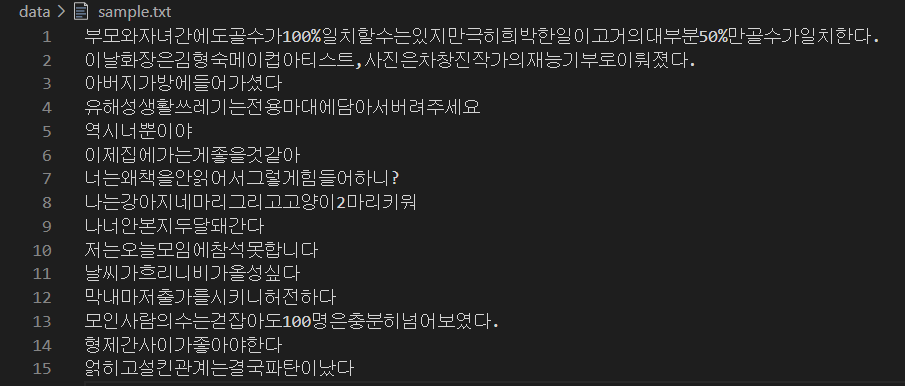

↓↓↓

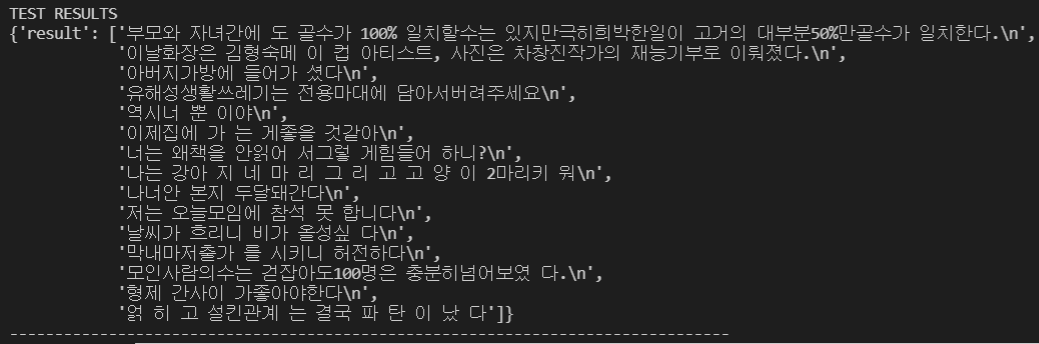